# Customizable Contraction Hierarchies

## Graph Representation
https://github.com/RoutingKit/RoutingKit/blob/master/doc/SupportFunctions.md

### Arc-List Form
In the arc-list form, we have two vectors: tail and head. Each entry in these vectors represents an edge in the graph, with tail[i] being the start of the edge and head[i] being the end. For our graph, the arc-list representation would be:

In [2]:
node_count = 5
tail = [0, 0, 1, 1, 2, 3]
head = [1, 2, 2, 3, 4, 4]

Visualizing this with graphviz

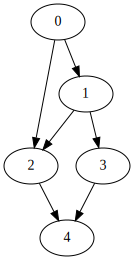

In [3]:
import graphviz

def visualize_graph(tail, head):
    # Create a new directed graph
    g = graphviz.Digraph(format='png')

    # Add edges to the graph
    for t, h in zip(tail, head):
        g.edge(str(t), str(h))

    return g

visualize_graph(tail, head)

### Adjacency-Array Form
In the adjacency-array form, we again have the `head` vector, but instead of `tail`, we have `first_out`. The `first_out` vector has `node_count` elements, with the first element being zero (because the tails of the 0-th node start at index 0 of the `head` vector).

In [4]:
first_out = [0, 2, 4, 5, 6, 6]
head = [1, 2, 2, 3, 4, 4]


In this form, first_out[i] gives us the index in head where the edges originating from node i start. So, if we wanted to iterate over all edges originating from a node x, we would do:

In [5]:
x = 4
for xy in range(first_out[x], first_out[x+1]):
    y = head[xy]
    print(f"x: {x} -> y: {y}")

The inverse vector $p$ of a vector $v$ is a vector such that the elements $v[p[i]], v[p[i]+1], v[p[i]+2], ..., v[p[i+1]-1]$ are exactly the elements with value $i$ in $v$. If $i$ does not occur in $v$, then $p[i] == p[i+1]$. $v$ must be a sorted vector of non-negative integers.

In [6]:
def invert_vector(v, element_count):
    index = [0]*(element_count+1)
    if len(v) == 0:
        return index
    else:
        assert v == sorted(v)
        assert max(v) < element_count

        pos = 0
        for i in range(element_count):
            while pos < len(v) and v[pos] < i:
                pos += 1
            index[i] = pos
        index[element_count] = len(v)
        return index

In [7]:
first_out = invert_vector(tail, node_count)
print(first_out)

[0, 2, 4, 5, 6, 6]


In [8]:
i = 0
v = tail
p = first_out
k = 0
print(f"v: {v}\np: {p}")
for j in range(len(tail)):
    k += 1
    if p[i] + k == len(v):
        break
    if v[p[i] + k]  != i:
        k = 0
        i += 1
    print(f"v[p[{i}] + {k}] = {v[p[i] + k]}")


v: [0, 0, 1, 1, 2, 3]
p: [0, 2, 4, 5, 6, 6]
v[p[0] + 1] = 0
v[p[1] + 0] = 1
v[p[1] + 1] = 1
v[p[2] + 0] = 2
v[p[3] + 0] = 3


In [9]:
def invert_inverse_vector(sorted_index):
    inv = [0]*(sorted_index[-1])
    for i in range(len(sorted_index)-1):
        for j in range(sorted_index[i], sorted_index[i+1]):
            inv[j] = i
    return inv

In [10]:
tail = invert_inverse_vector(first_out)
print(f"tail: {tail}")

tail: [0, 0, 1, 1, 2, 3]


## Some Test Graphs

In [11]:
class Graph():
    def __init__(self, tail, head, dist, node_count):

        self.tail, self.head, self.dist = zip(*sorted(zip(tail, head, dist)))
        self.first_out = invert_vector(tail, node_count)

        self.node_count = node_count
        self.edge_count = len(tail)



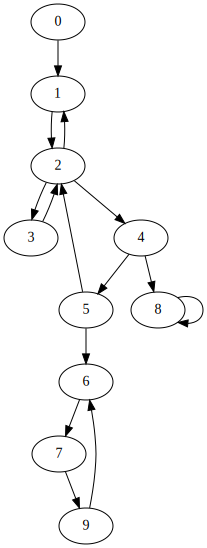

In [12]:
# Graph
node_count = 11
tail = [0, 1, 2, 2, 2, 3, 4, 4, 5, 5, 6, 7, 8, 9]
head = [1, 2, 1, 3, 4, 2, 5, 8, 2, 6, 7, 9, 8, 6]
first_out = invert_vector(tail, node_count)
visualize_graph(tail, head)

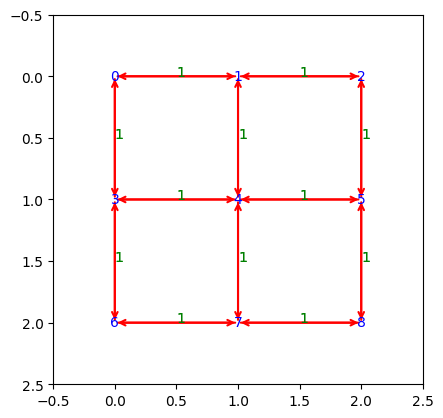

In [13]:
# Grid Graph
def create_grid_graph(width, height):
    node_count = width * height
    tail = []
    head = []
    dist = []
    for i in range(node_count):
        # right edge
        if i % width != width - 1:
            tail.append(i)
            head.append(i+1)
            # dist.append(1)
        # left edge
        if i % width != 0:
            tail.append(i)
            head.append(i-1)
            # dist.append(2)
        # top edge
        if i >= width:
            tail.append(i)
            head.append(i-width)
            # dist.append(3)
        # bottom edge
        if i < node_count - width:
            tail.append(i)
            head.append(i+width)
            # dist.append(4)
    dist = [1]*len(tail)
    
    return Graph(tail, head, dist, node_count)

import matplotlib.pyplot as plt
import numpy as np

def visualize_grid_graph(G, width, height):
    # Unpack the graph
    first_out = G.first_out
    head = G.head
    dist = G.dist
    
    # Create a grid of cells
    grid = np.zeros((height, width))

    # Draw the nodes of the graph as cells in the grid
    fig, ax = plt.subplots()
    ax.imshow(grid, cmap='binary')

    # Draw the edges of the graph as lines between cells
    for i in range(len(first_out)-1):
        for j in range(first_out[i], first_out[i+1]):
            # Compute the coordinates of the nodes
            x1, y1 = i % width, i // width
            x2, y2 = head[j] % width, head[j] // width

            # Draw a line between the nodes with an arrow head
            ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                        arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
                        ha='right', va='top')

            # Annotate the line with the distance, offset from the midpoint
            ax.text((x1 + x2) / 2, (y1 + y2) / 2, str(dist[j]), color='green')

    # Annotate each cell with its node id
    for i in range(height):
        for j in range(width):
            ax.text(j, i, str(i*width + j), ha='center', va='center', color='blue')

    # Display the plot
    plt.show()


width, height = 3, 3
G = create_grid_graph(width, height)
visualize_grid_graph(G, width, height)

## Dijkstra's Algorithm

In [15]:
from collections import defaultdict
import heapq as heap

def dijkstra(G, source, target):
    visited = set()
    parents_map = {}
    pq = []
    node_dists = defaultdict(lambda: float('inf'))
    node_dists[source] = 0
    heap.heappush(pq, (0, source))

    while len(pq) > 0:
        print(pq)
        dist, node = heap.heappop(pq)
        visited.add(node)

        if node == target:
            break
        for i in range(G.first_out[node], G.first_out[node+1]):
            neighbor = G.head[i]
            if neighbor not in visited:
                new_dist = dist + G.dist[i]
                if new_dist < node_dists[neighbor]:
                    node_dists[neighbor] = new_dist
                    parents_map[neighbor] = node
                    heap.heappush(pq, (new_dist, neighbor))
    
    path = []
    node = target
    while node != source:
        path.append(node)
        node = parents_map[node]
    path.append(source)
    path.reverse()
    print(f"Path from {source} to {target}: {path}")
    print(f"Distance: {node_dists[target]}")

dijkstra(G, 0, 8)

[(0, 0)]
[(1, 1), (1, 3)]
[(1, 3), (2, 2), (2, 4)]
[(2, 2), (2, 4), (2, 6)]
[(2, 4), (2, 6), (3, 5)]
[(2, 6), (3, 5), (3, 7)]
[(3, 5), (3, 7)]
[(3, 7), (4, 8)]
[(4, 8)]
Path from 0 to 8: [0, 1, 2, 5, 8]
Distance: 4


In [20]:
pq = []
heap.heappush(pq, (0, 'a'))
heap.heappush(pq, (1, 'b'))
heap.heappush(pq, (0, 'a'))
print(pq)
print(heap.heappop(pq))
print(heap.heappop(pq))
print(heap.heappop(pq))

[(0, 'a'), (1, 'b'), (0, 'a')]
(0, 'a')
(0, 'a')
(1, 'b')


# Optimization embedded in Graph search subroutines

## Optimization Dijkstra

In [ ]:
from collections import defaultdict
import heapq as heap

def convex_dijkstra(G, source, target):
    visited = set()
    parents_map = {}
    pq = []
    node_dists = defaultdict(lambda: float('inf'))
    node_dists[source] = 0
    heap.heappush(pq, (0, source))

    # Each node is a convex set

    while len(pq) > 0:
        dist, node = heap.heappop(pq)
        visited.add(node)

        if node == target:
            break
        for i in range(G.first_out[node], G.first_out[node+1]):
            neighbor = G.head[i]
            if neighbor not in visited:
                # Solve convex optimization for dist from source to neighbor
                # The order of nodes is fixed, so it's a convex program
                new_dist = dist + G.dist[i] # REPLACE
                
                if new_dist < node_dists[neighbor]:
                    node_dists[neighbor] = new_dist
                    parents_map[neighbor] = node
                    heap.heappush(pq, (new_dist, neighbor))
    
    path = []
    node = target
    while node != source:
        path.append(node)
        node = parents_map[node]
    path.append(source)
    path.reverse()
    print(f"Path from {source} to {target}: {path}")
    print(f"Distance: {node_dists[target]}")

dijkstra(G, 0, 8)

## Contraction Hierarchies

In [65]:
# https://codereview.stackexchange.com/questions/277012/python-code-to-contract-shrink-a-graph

import random
from dataclasses import dataclass
from string import ascii_uppercase, ascii_lowercase
from typing import Iterable, NewType, Optional, Sequence

import graphviz


Vertex = NewType('Vertex', str)


def array_to_str(array: Iterable) -> list[str]:
    return [str(x) for x in array]


class Graph:
    def __init__(self, edges: set['Edge'], vertices: set[Vertex]) -> None:
        self.edges = edges
        self.vertices = vertices

    def subgraph(
        self,
        vertices: Optional[set[Vertex]] = None,
        edges: Optional[set['Edge']] = None,
    ) -> 'Graph':
        if vertices is not None:
            ret_vertices = self.vertices & vertices
            ret_edges = {
                edge for edge in self.edges
                if edge.vertices <= ret_vertices
            }
            return Graph(ret_edges, ret_vertices)

        if edges is not None:
            ret_edges = self.edges & edges
            ret_vertices = {
                *(edge.a for edge in ret_edges),
                *(edge.b for edge in ret_edges),
            }
            return Graph(ret_edges, ret_vertices)

        raise ValueError('nodes and edges are None')

    def without(self, another_graph: 'Graph') -> 'Graph':
        ret_vertices = self.vertices - another_graph.vertices
        ret_edges = self.edges - another_graph.edges
        return Graph(ret_edges, ret_vertices)

    def __str__(self) -> str:
        return f'Vertices: {self.vertices}, Edges: {array_to_str(self.edges)}'


@dataclass(frozen=True)
class Edge:
    a: Vertex
    b: Vertex

    def __eq__(self, other: 'Edge') -> bool:
        return self.a == other.a and self.b == other.b

    @property
    def vertices(self) -> set[Vertex]:
        return {self.a, self.b}

    def reversed(self) -> 'Edge':
        return Edge(self.b, self.a)

    def __str__(self) -> str:
        return f'{self.a} --> {self.b}'

    def touches(self, vertex: Vertex) -> bool:
        return vertex in self.vertices

    @property
    def is_reflexive(self) -> bool:
        return self.a == self.b


LABELS: Sequence[Vertex] = ascii_uppercase + ascii_lowercase


def remove_duplicates(edges: set[Edge]) -> set[Edge]:
    ret = edges - {edge.reversed() for edge in edges}
    return ret


def remove_lonely_nodes(edges: Iterable[Edge]) -> set[Vertex]:
    reached_nodes = {
        vertex
        for edge in edges
        for vertex in edge.vertices
    }
    return reached_nodes


def create_random_graph(node_count: int, edge_count: int) -> Graph:
    nodes = list(LABELS[:node_count])

    edges = {
        Edge(
            a=random.choice(nodes),
            b=random.choice(nodes),
        )
        for _ in range(edge_count)
    }

    edges = remove_duplicates(edges)
    nodes = remove_lonely_nodes(edges)

    return Graph(edges, nodes)


def random_graph() -> None:
    g = create_random_graph(15, 25)

    subset_edges = set(random.sample(list(g.edges), k=7))

    # h1 = g.subgraph(vertices=subset_vertices)
    h2 = g.subgraph(edges=subset_edges)

    # g1 = g.without(h1)
    g2 = g.without(h2)

    dot = graphviz.Graph()
    for e in g2.edges:
        dot.edge(e.a, e.b, color='red')
    for v in g2.vertices:
        dot.node(v, color='red')
    for e in h2.edges:
        dot.edge(e.a, e.b, color='green')
    for v in h2.vertices:
        dot.node(v, color='green')
    dot.render(directory='doctest-output', view=True)


def has_reflexive_edges(sub_edges: Iterable[Edge]) -> bool:
    return any(edge.is_reflexive for edge in sub_edges)


def has_adjacent_reflexive_edges(sub_edges: set[Edge], graph: Graph) -> bool:
    return not graph.edges.isdisjoint(
        vertex
        for edge in sub_edges
        for vertex in edge.vertices
    )


def random_entries(collection: set[Edge], count: int) -> set[Edge]:
    return set(random.sample(population=list(collection), k=count))


def contract_graph() -> None:
    def other_vertex(edge: Edge, vertex: Vertex) -> Vertex:
        if edge.a == vertex:
            return edge.b
        if edge.b == vertex:
            return edge.a
        raise ValueError(f'{edge} does not contain {vertex}!')

    g = create_random_graph(20, 40)

    while True:
        subset_edges = random_entries(g.edges, 2)
        if not (
            has_reflexive_edges(subset_edges)
            or has_adjacent_reflexive_edges(subset_edges, g)
        ):
            break

    subgraph_to_be_contracted = g.subgraph(edges=subset_edges)
    x_vertices = subgraph_to_be_contracted.vertices
    g_without_x = g.without(subgraph_to_be_contracted)
    edges_x_to_not_x = {
        edge for edge in g.edges
        # if not x_vertices.isdisjoint(edge.vertices)
        if (edge.a in x_vertices) ^ (edge.b in x_vertices)
    }
    tmp = Graph(edges_x_to_not_x, set())
    g_without_inter_edges = g_without_x.without(tmp)

    new_x = Vertex('newX')
    new_edges_to_new_x = []

    for edge in edges_x_to_not_x:
        for x in x_vertices:
            if edge.touches(x):
                other = other_vertex(edge, x)
                new_edges_to_new_x.append(Edge(other, new_x))

    if len(new_edges_to_new_x) != len(edges_x_to_not_x):
        raise ValueError('Length mismatch')

    dot = graphviz.Graph()
    for e in subgraph_to_be_contracted.edges:
        dot.edge(e.a, e.b, color='red')
    for v in subgraph_to_be_contracted.vertices:
        dot.node(v, color='red')
    for e in g_without_inter_edges.edges:
        dot.edge(e.a, e.b, color='grey')
    for v in g_without_inter_edges.vertices:
        dot.node(v, color='grey')
    for e in edges_x_to_not_x:
        dot.edge(e.a, e.b, color='orange')
    for e in new_edges_to_new_x:
        dot.edge(e.a, e.b, color='green')
    dot.node(new_x, color='green')
    dot.render(directory='doctest-output', view=True)


random.seed(0)
# random_graph()
contract_graph()